In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append('./src')
from geometry import *
from tubes import closed_geometry
from solver import stokes2d

In [2]:
p1 = np.array([-10,-1])
curve1 = line

p2 = np.array([-1,-1])
curve2 = line

p3 = np.array([-1,-10])
curve3 = cap

p4 = np.array([1,-10])
curve4 = line

p5 = np.array([1,-1])
curve5 = line

p6 = np.array([10,-1])
curve6 = cap

p7 = np.array([10,1])
curve7 = line

p8 = np.array([1,1])
curve8 = line

p9 = np.array([1,10])
curve9 = cap

p10 = np.array([-1,10])
curve10 = line

p11 = np.array([-1,1])
curve11 = line

p12 = np.array([-10,1])
curve12 = cap

In [3]:
pts = [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12]
curves = [curve1, curve2, curve3, curve4, curve5, curve6, curve7, curve8, curve9, curve10, curve11, curve12]

In [4]:
cross = closed_geometry(pts,curves,corner_size=0.2)

In [5]:
cross.build_geometry(2e-2)

# solvers, pressure drops, velocity field

In [6]:
solver = stokes2d(cross,gmres_tol=1e-13)

: 

: 

In [ ]:
inflow = cross.caps[0]
outflows = cross.caps[1:]
flows = [(inflow,outflow) for outflow in outflows]

In [ ]:
def get_boundary_velocity_conditions(flow):
    velocity = []
    for i,c in enumerate(cross.curves):
        if i == flow[0]:
            velocity.append(c.get_velocity(flux=1))
        elif i == flow[1]:
            velocity.append(c.get_velocity(flux=-1))
        else:
            velocity.append(c.get_velocity(flux=0))
    return np.concatenate(velocity)

flows_boundary_conditions = [get_boundary_velocity_conditions(flow) for flow in flows]

In [8]:
cross.curves[5]

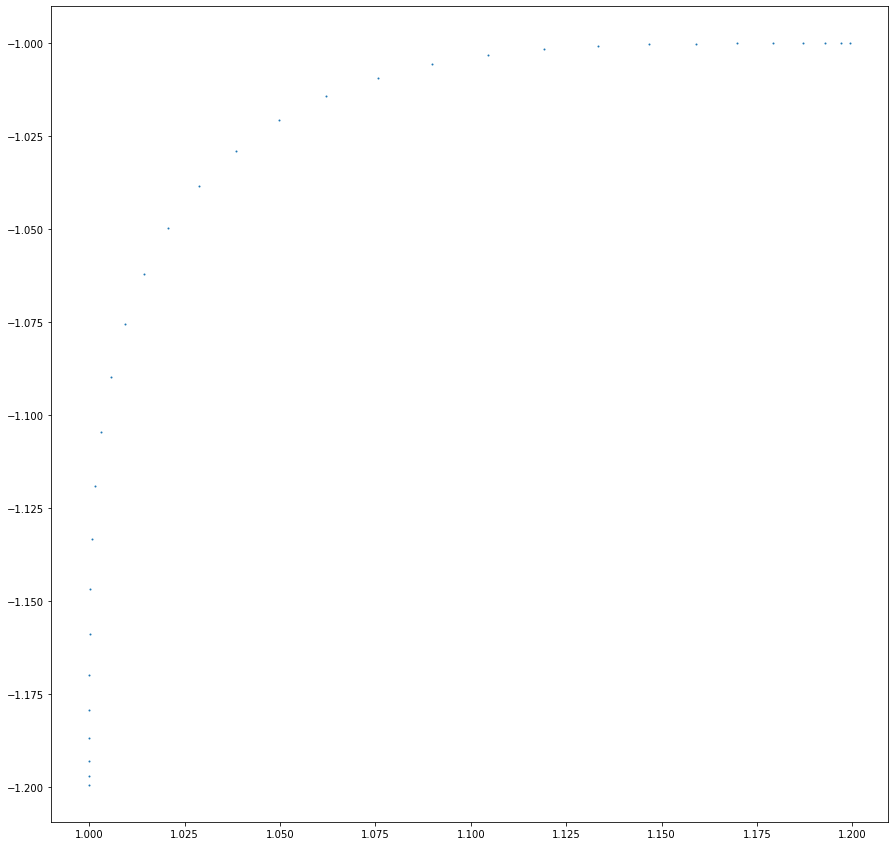

In [10]:
plt.figure(figsize=(15,15))
plt.scatter(cross.curves[5].x, cross.curves[5].y, s=1)

heuristic, curvature, expansion, 

- see if legendre coefficients decayed. dx_da, dy_da, not higher order derivatives. 

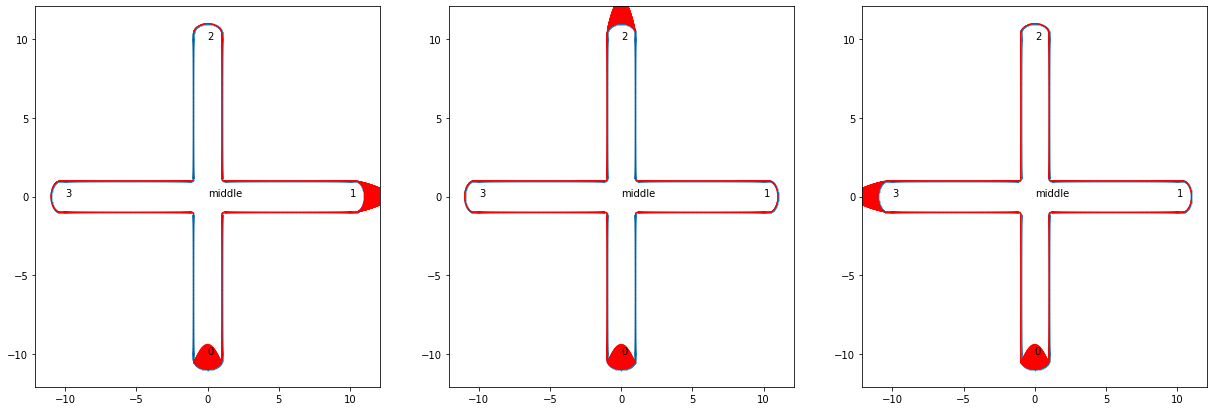

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(21,7))
for i in range(3):
    axes[i].scatter(cross.x,cross.y,s=0.1)
    axes[i].quiver(cross.x,cross.y,flows_boundary_conditions[i][:,0],flows_boundary_conditions[i][:,1],scale=10,color='r')
    for k,j in enumerate(cross.caps):
        axes[i].text(cross.curves[j].p[0],cross.curves[j].p[1],str(k))
    axes[i].text(0,0,'middle')
    

In [ ]:
flows_omega = [solver.solve(flows_boundary_condition) for flows_boundary_condition in flows_boundary_conditions]

gmres starts solving the Nystorm, please wait...
gmres converged
gmres starts solving the Nystorm, please wait...
gmres converged
gmres starts solving the Nystorm, please wait...
gmres converged


In [ ]:
solver.clean_A()

In [ ]:
mid_point = np.array([0,0])
pressure_drops = []

flow_lines = []

for i,o in flows:
    start = cross.curves[i].p
    end = cross.curves[o].p
    line1 = line(start,mid_point)
    line1.build(2e-4)
    line2 = line(mid_point,end)
    line2.build(2e-4)
    flow_lines.append((line1,line2))
    

for i in range(len(flows)):
    # computing the pressure drop with unit flux of the flow i. 
    omega = flows_omega[i]
    pressure_drop = []

    for k,j in enumerate(flows):
        # integrating the pressure drop in the flow j. 
        line1,line2 = flow_lines[k]
        grad1 = solver.compute_grad_pressure(line1.get_t(),omega)
        grad2 = solver.compute_grad_pressure(line2.get_t(),omega)
        pressure_drop.append(np.sum(
            (grad1[:,0]*line1.dx_da + grad1[:,1]*line1.dy_da)*line1.da + \
            (grad2[:,0]*line2.dx_da + grad2[:,1]*line2.dy_da)*line2.da))
        
    pressure_drops.append(pressure_drop)

: 

: 

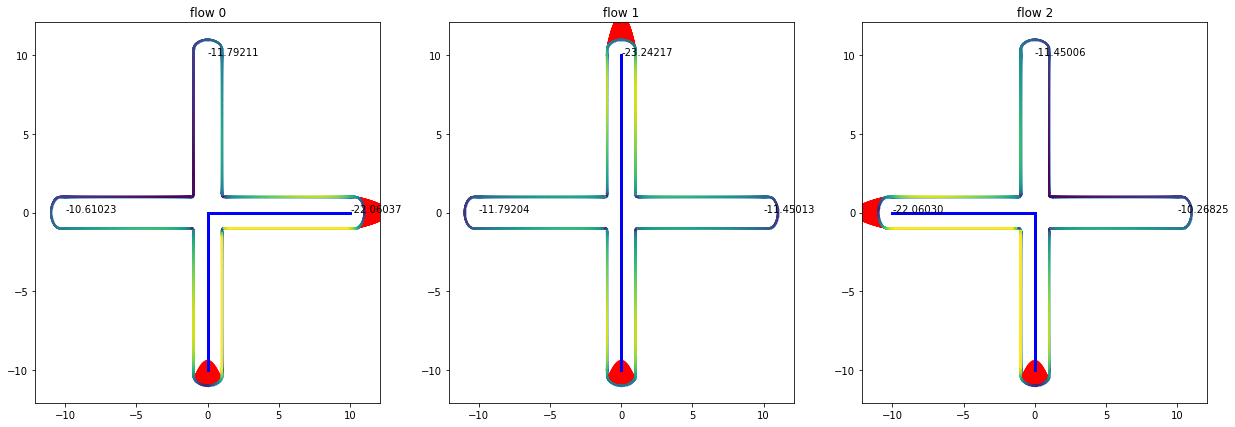

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(21,7))
for i in range(3):
    axes[i].scatter(cross.x,cross.y,s=0.1)
    axes[i].quiver(cross.x,cross.y,flows_boundary_conditions[i][:,0],flows_boundary_conditions[i][:,1],scale=10,color='r')
    axes[i].title.set_text('flow '+str(i))
    axes[i].scatter(flow_lines[i][0].x,flow_lines[i][0].y,s=1,color='b')
    axes[i].scatter(flow_lines[i][1].x,flow_lines[i][1].y,s=1,color='b')
    
    for j in range(3):
        out = flows[j][1]
        end_point = cross.curves[out].p
        axes[i].text(end_point[0],end_point[1], f'{pressure_drops[i][j]:.5f}')
        
    axes[i].scatter(cross.x,cross.y,s=1,c=np.abs(flows_omega[i]),vmin=0,vmax=10)


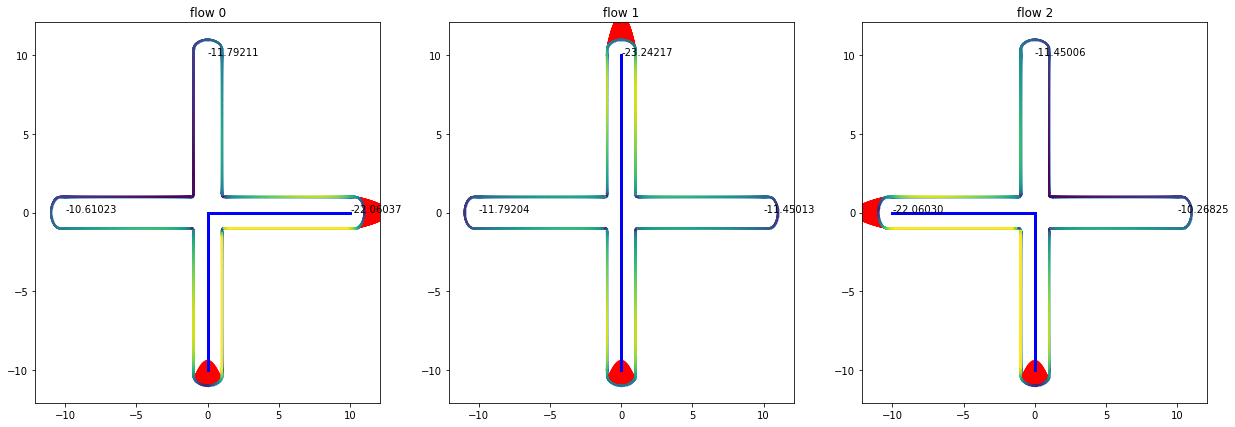

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(21,7))
for i in range(3):
    axes[i].scatter(cross.x,cross.y,s=0.1)
    axes[i].quiver(cross.x,cross.y,flows_boundary_conditions[i][:,0],flows_boundary_conditions[i][:,1],scale=10,color='r')
    axes[i].title.set_text('flow '+str(i))
    axes[i].scatter(flow_lines[i][0].x,flow_lines[i][0].y,s=1,color='b')
    axes[i].scatter(flow_lines[i][1].x,flow_lines[i][1].y,s=1,color='b')
    
    for j in range(3):
        out = flows[j][1]
        end_point = cross.curves[out].p
        axes[i].text(end_point[0],end_point[1], f'{pressure_drops[i][j]:.5f}')
        
    axes[i].scatter(cross.x,cross.y,s=1,c=np.abs(flows_omega[i]),vmin=0,vmax=10)


In [28]:
[sum(i) for i in pressure_drops]

[-44.46270502137277, -46.484345326711995, -43.77861741817493]

In [36]:
sys.getsizeof(flows_omega[0])/1024/1024

0.1583099365234375

In [37]:
flows_omega[0].shape

(10368,)